## **Data Pre-processing**

### Read the CSV file from HDFS

In [25]:
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder \
    .appName("Big_Data") \
    .getOrCreate()

# Read the CSV file from HDFS
file_path = "hdfs://localhost:9000/user/Nirmin/data/2019-Oct.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)


# Show the first few rows
df.show()

# Count the number of rows
row_count = df.count()

# Print the row count
print(f"The total number of rows in the dataset is: {row_count}")


+-------------------+----------+----------+-------------------+--------------------+--------+-------+---------+--------------------+
|         event_time|event_type|product_id|        category_id|       category_code|   brand|  price|  user_id|        user_session|
+-------------------+----------+----------+-------------------+--------------------+--------+-------+---------+--------------------+
|2019-10-01 02:00:00|      view|  44600062|2103807459595387724|                NULL|shiseido|  35.79|541312140|72d76fde-8bb3-4e0...|
|2019-10-01 02:00:00|      view|   3900821|2053013552326770905|appliances.enviro...|    aqua|   33.2|554748717|9333dfbd-b87a-470...|
|2019-10-01 02:00:01|      view|  17200506|2053013559792632471|furniture.living_...|    NULL|  543.1|519107250|566511c2-e2e3-422...|
|2019-10-01 02:00:01|      view|   1307067|2053013558920217191|  computers.notebook|  lenovo| 251.74|550050854|7c90fc70-0e80-459...|
|2019-10-01 02:00:04|      view|   1004237|2053013555631882655|electr

### Handle Missing Values

In [27]:
df = df.na.fill({"brand": "unknown_brand"})
df = df.na.fill({"category_code": "unknown_ctg"})

In [28]:
from pyspark.sql.functions import col, sum
missing_data = df.select(
    [sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]
)

# Show the count of missing values for each column
print("Count of missing values per column:")
missing_data.show()



Count of missing values per column:
+----------+----------+----------+-----------+-------------+-----+-----+-------+------------+
|event_time|event_type|product_id|category_id|category_code|brand|price|user_id|user_session|
+----------+----------+----------+-----------+-------------+-----+-----+-------+------------+
|         0|         0|         0|          0|            0|    0|    0|      0|           2|
+----------+----------+----------+-----------+-------------+-----+-----+-------+------------+



### Remove Duplicates

In [30]:
# Count duplicates before removing
duplicates = df.groupBy(df.columns).count().filter("count > 1")
total_duplicates = duplicates.selectExpr("sum(count - 1) as total_duplicates").collect()[0]["total_duplicates"]
print(f"Total duplicate rows before removal: {total_duplicates}")

# Remove duplicates
df = df.dropDuplicates()

# Verify duplicate removal
total_rows_after = df.count()
print(f"Total rows after duplicate removal: {total_rows_after}")

Total duplicate rows before removal: 30220
Total rows after duplicate removal: 42418544


### Count the rows with price = 0.0

In [32]:
# Filter rows where price is 0.0
zero_price_rows = df.filter(col("price") == 0.0)

# Count the rows with price = 0.0
count_zero_price = zero_price_rows.count()
print(f"Total number of rows with price = 0.0: {count_zero_price}")

Total number of rows with price = 0.0: 68670


### Remove rows where price= 0.0

In [34]:
 # Filter out rows where price = 0.0
df = df.filter(col("price") > 0.0)

total_rows_after = df.count()
print(f"Total rows after removing 0.0 price: {total_rows_after}")

Total rows after removing 0.0 price: 42349874


### Columns to drop

In [36]:
columns_to_drop = ["category_id", "user_session"]  # Add other columns if needed

df = df.drop(*columns_to_drop)

print("Columns dropped successfully.")
df.printSchema()


Columns dropped successfully.
root
 |-- event_time: timestamp (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- category_code: string (nullable = false)
 |-- brand: string (nullable = false)
 |-- price: double (nullable = true)
 |-- user_id: integer (nullable = true)



### Handle Outliers

## **Analyze Pre-Processed Data**

In [39]:
df.describe("price").show()

+-------+-----------------+
|summary|            price|
+-------+-----------------+
|  count|         42349874|
|   mean|290.7840087835735|
| stddev|358.3967881151065|
|    min|             0.77|
|    max|          2574.07|
+-------+-----------------+



In [40]:
from pyspark.sql.functions import count

# Count of event types
event_counts = df.groupBy("event_type").agg(count("*").alias("count"))
event_counts.show()

+----------+--------+
|event_type|   count|
+----------+--------+
|  purchase|  742773|
|      view|40708807|
|      cart|  898294|
+----------+--------+



In [41]:
# Show column names and data types
print("Data Types for each column:")
for column, dtype in df.dtypes:
    print(f"{column}: {dtype}")


Data Types for each column:
event_time: timestamp
event_type: string
product_id: int
category_code: string
brand: string
price: double
user_id: int


In [42]:
# Top brands
top_brands = df.groupBy("brand").count().orderBy("count", ascending=False)
top_brands.show(10)



+-------------+-------+
|        brand|  count|
+-------------+-------+
|unknown_brand|6043456|
|      samsung|5271172|
|        apple|4116981|
|       xiaomi|3080998|
|       huawei|1109758|
|      lucente| 655818|
|           lg| 561883|
|        bosch| 556877|
|         oppo| 482131|
|         sony| 456429|
+-------------+-------+
only showing top 10 rows



In [43]:
from pyspark.sql.functions import col, sum, desc
# Group by user_id and calculate total spending
user_spending = df.groupBy("user_id").agg(sum("price").alias("total_spent"))

# Sort the users by total spending in descending order
top_users = user_spending.orderBy(desc("total_spent"))

# Show the top 10 users who spent the most money
print("Top 10 users by total spending:")
top_users.show(10)

Top 10 users by total spending:
+---------+------------------+
|  user_id|       total_spent|
+---------+------------------+
|563459593|        1993636.41|
|536399452| 1692370.919999999|
|512365995|        1499595.88|
|561163588|        1451590.78|
|545925192|1265846.7000000002|
|512845454|1116256.8399999999|
|513900355|        1030680.81|
|519267944|         975366.29|
|526731152| 935684.4600000001|
|513117637| 919921.9599999997|
+---------+------------------+
only showing top 10 rows



### Event Type Analysis

In [45]:
from pyspark.sql.functions import count

# Count each event type
event_type_distribution = df.groupBy("event_type").agg(count("*").alias("event_count"))
event_type_distribution.show()

# Convert to percentage
total_events = df.count()
event_type_distribution = event_type_distribution.withColumn("event_percentage", (col("event_count") / total_events) * 100)
event_type_distribution.show()


+----------+-----------+
|event_type|event_count|
+----------+-----------+
|  purchase|     742773|
|      view|   40708807|
|      cart|     898294|
+----------+-----------+

+----------+-----------+------------------+
|event_type|event_count|  event_percentage|
+----------+-----------+------------------+
|  purchase|     742773|1.7538965995506857|
|      view|   40708807| 96.12497784527056|
|      cart|     898294|2.1211255551787476|
+----------+-----------+------------------+



### Top Categories and Brands

In [47]:
from pyspark.sql.functions import sum

# Top categories by revenue
category_revenue = df.groupBy("category_code").agg(sum("price").alias("total_revenue")).orderBy("total_revenue", ascending=False)
category_revenue.show(10)

# Top brands by revenue
brand_revenue = df.groupBy("brand").agg(sum("price").alias("total_revenue")).orderBy("total_revenue", ascending=False)
brand_revenue.show(10)


+--------------------+--------------------+
|       category_code|       total_revenue|
+--------------------+--------------------+
|electronics.smart...| 5.424022839950075E9|
|         unknown_ctg| 2.498809041610009E9|
|  computers.notebook| 8.089725903200045E8|
|electronics.video.tv|4.9170103094000155E8|
|  electronics.clocks| 3.858749984500045E8|
|appliances.kitche...| 3.522492002700012E8|
|appliances.kitche...| 2.875460452499985E8|
|   computers.desktop|2.2724032760999876E8|
|appliances.enviro...|1.3559645698999768E8|
|furniture.living_...|1.3417894981000152E8|
+--------------------+--------------------+
only showing top 10 rows

+-------------+--------------------+
|        brand|       total_revenue|
+-------------+--------------------+
|        apple|3.4266640361501684E9|
|      samsung|1.7423186623099718E9|
|unknown_brand| 1.204327127580039E9|
|       xiaomi| 6.177687643299739E8|
|       huawei| 2.936906300799977E8|
|         acer|2.5849501696000072E8|
|           lg|2.53757731

### User Behavior

In [49]:
# Top 10 users by spending
top_users = df.groupBy("user_id").agg(sum("price").alias("total_spent")).orderBy("total_spent", ascending=False)
top_users.show(10)


+---------+------------------+
|  user_id|       total_spent|
+---------+------------------+
|563459593|        1993636.41|
|536399452| 1692370.919999999|
|512365995|        1499595.88|
|561163588|        1451590.78|
|545925192|1265846.7000000002|
|512845454|1116256.8399999999|
|513900355|        1030680.81|
|519267944|         975366.29|
|526731152| 935684.4600000001|
|513117637| 919921.9599999997|
+---------+------------------+
only showing top 10 rows



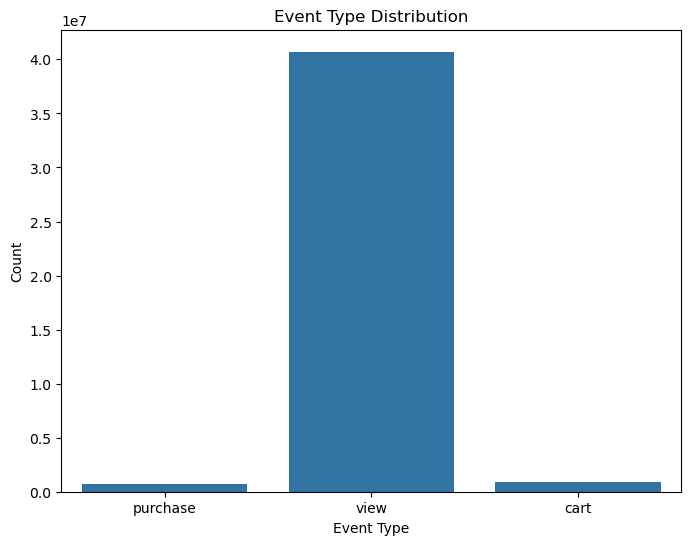

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert event type distribution to Pandas
event_type_pd = event_type_distribution.toPandas()

# Plot event type distribution
plt.figure(figsize=(8, 6))
sns.barplot(x="event_type", y="event_count", data=event_type_pd)
plt.title("Event Type Distribution")
plt.xlabel("Event Type")
plt.ylabel("Count")
plt.show()


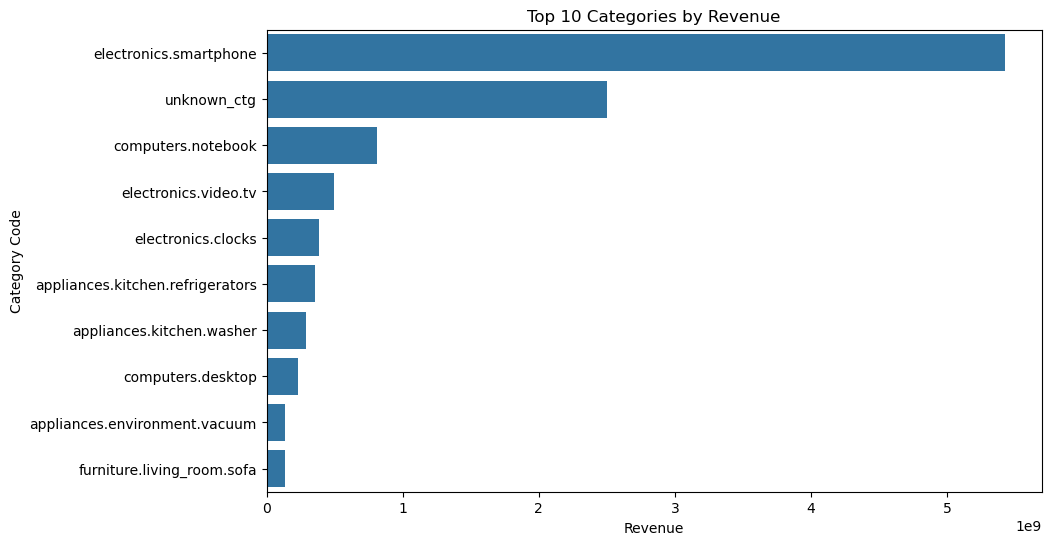

In [51]:
# Convert category revenue to Pandas
category_revenue_pd = category_revenue.limit(10).toPandas()

# Plot category revenue
plt.figure(figsize=(10, 6))
sns.barplot(x="total_revenue", y="category_code", data=category_revenue_pd)
plt.title("Top 10 Categories by Revenue")
plt.xlabel("Revenue")
plt.ylabel("Category Code")
plt.show()


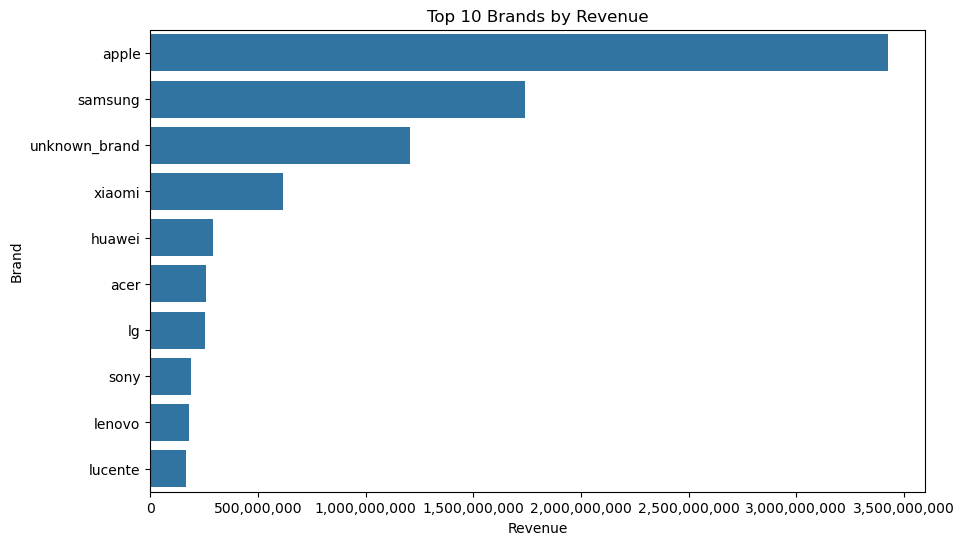

In [52]:
from matplotlib.ticker import FuncFormatter

brand_revenue_pd = brand_revenue.limit(10).toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(x="total_revenue", y="brand", data=brand_revenue_pd)
plt.title("Top 10 Brands by Revenue")
plt.xlabel("Revenue")
plt.ylabel("Brand")

plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x):,}"))

plt.show()

### Which days are busiest?

C:\Users\Nirmin\AppData\Local\Temp\ipykernel_20688\3530618921.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  weekly_visits = daily_visits_pd.groupby("day_of_week")["visit_count"].sum().reindex(day_order)


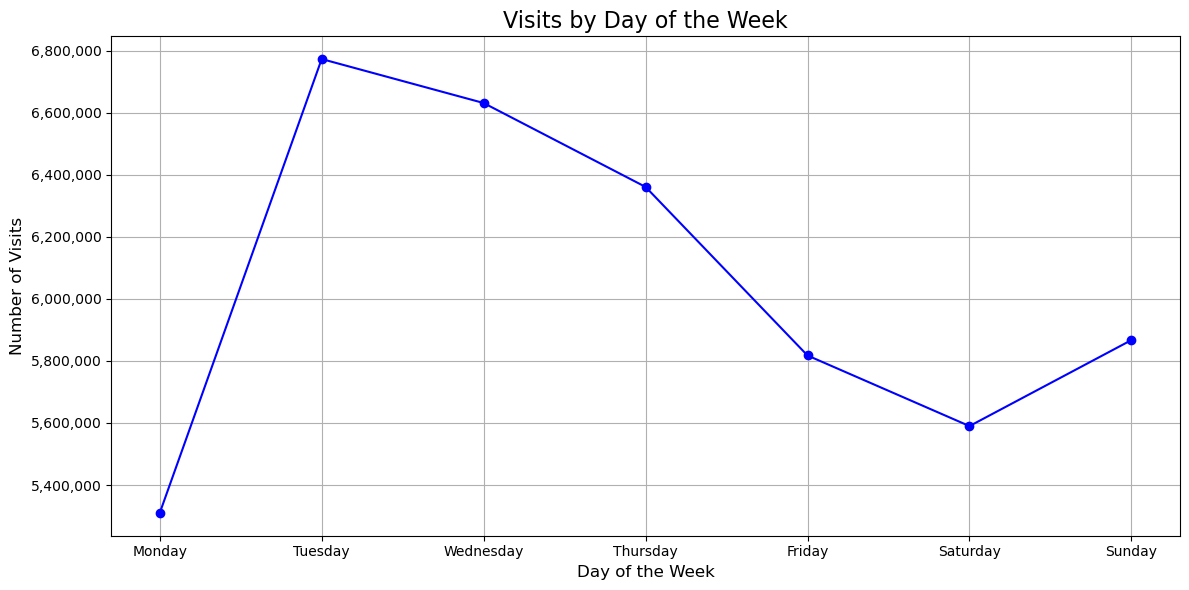

In [54]:
from pyspark.sql import functions

# -- ⚠️ In case of error, uncomment the following lines:

# data = df.withColumn("event_time_clean", functions.regexp_replace(functions.col("event_time"), " UTC", ""))
# data = df.withColumn(
#    "event_date",
#    functions.to_date(
#        functions.col("event_time_clean"),
#        "yyyy-MM-dd HH:mm:ss"
#    )
# )

# -- ⚠️ In case of error,
# -- replace `event_time` with `event_date`,
# -- after uncommenting the lines above ^
daily_visits = (
    df.groupBy("event_time")
    .agg(functions.count("*").alias("visit_count"))
    .orderBy("event_time")
)

daily_visits_pd = daily_visits.toPandas()

from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import pandas as pd

daily_visits_pd["day_of_week"] = pd.to_datetime(daily_visits_pd["event_time"]).dt.day_name()

day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
daily_visits_pd["day_of_week"] = pd.Categorical(daily_visits_pd["day_of_week"], categories=day_order, ordered=True)

weekly_visits = daily_visits_pd.groupby("day_of_week")["visit_count"].sum().reindex(day_order)

plt.figure(figsize=(12, 6))
plt.plot(
    weekly_visits.index,
    weekly_visits.values,
    marker="o",
    linestyle="-",
    color="b",
)
plt.title("Visits by Day of the Week", fontsize=16)
plt.xlabel("Day of the Week", fontsize=12)
plt.ylabel("Number of Visits", fontsize=12)
plt.grid(True)

plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x):,}"))

plt.tight_layout()
plt.show()


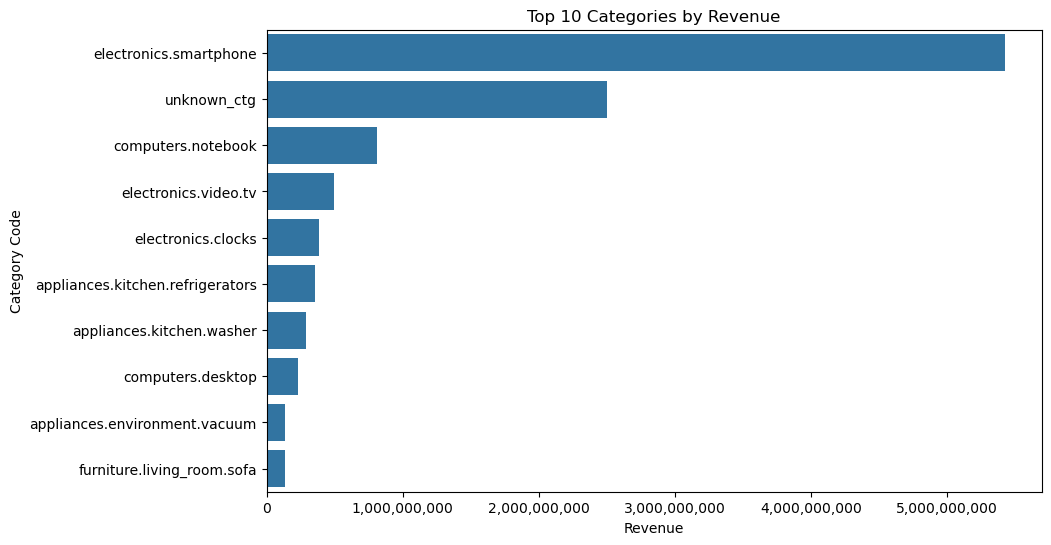

In [74]:
from matplotlib.ticker import FuncFormatter
# Convert category revenue to Pandas
category_revenue_pd = category_revenue.limit(10).toPandas()
  
# Plot category revenue
plt.figure(figsize=(10, 6))
sns.barplot(x="total_revenue", y="category_code", data=category_revenue_pd)
plt.title("Top 10 Categories by Revenue")
plt.xlabel("Revenue")
plt.ylabel("Category Code")

plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x):,}"))

plt.show()